In [1]:
using Plots, PlotThemes, HTTP, Gumbo, DataInterpolations
#set_theme(:dark)

# Upper Atmosphere Modelling
Using data from: http://www.braeunig.us/space/atmos.htm

In [1]:
r = HTTP.request("GET", "http://www.braeunig.us/space/atmos.htm")
r.status

LoadError: UndefVarError: HTTP not defined

In [3]:
# parsing and getting body
r_parsed = parsehtml(String(r.body))
body = r_parsed.root[2];

In [4]:
# table 2, MSISE-90 Model with mean solar activity
alts_t2, densities_t2 = Vector{Float64}(), Vector{Float64}()

for i in 10:50
    row = body[2][1][3][2][1][1][i]

    push!(alts_t2, parse(Float64, row[1][1][1].text))
    push!(densities_t2, parse(Float64, row[7][1][1].text))
end

In [5]:
# table 3 data
alts_t3, densities_t3 = Vector{Float64}(), Vector{Float64}()

for i in 6:22
    row = body[2][1][4][2][1][1][i]

    push!(alts_t3, parse(Float64, row[1][1][1].text))
    push!(densities_t3, parse(Float64, row[3][1][1].text))
end

In [6]:
orbit_alts = LinRange(100,900,500)
density_interp = QuadraticInterpolation(densities_t2, alts_t2);

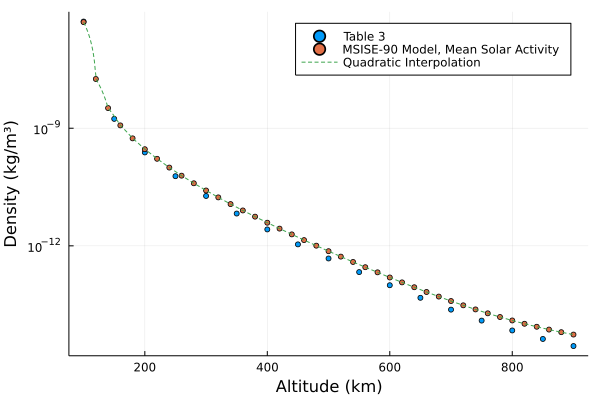

In [7]:
fig1 = scatter(
    alts_t3, densities_t3, 
    yaxis=:log,
    ylabel="Density (kg/m³)",
    xlabel="Altitude (km)",
    label="Table 3",
    markersize=3,
    tex_output_standalone = true,
    legend=:topright
)

scatter!(alts_t2, densities_t2, label="MSISE-90 Model, Mean Solar Activity", markersize=3)

plot!(orbit_alts, density_interp.(orbit_alts), linestyle=:dash, label="Quadratic Interpolation")

In [17]:
savefig(fig1, "fig1.tex")

# Disturbance Torque Modelling

In [8]:
# defining constants
A_s = 2.287

Cd = 2.25
Cg = 0.2595
Cp = 0.1949

re = 6378
μ = 398600;

In [9]:
# gravity gradient torques
J = [
    66.4151 0 0 
    0 66.4151 0
    0 0 116.163
]

Tg = (3*μ./((re .+ orbit_alts).^3)) * (J[3,3] - J[2,2]) * sin(2 * deg2rad(1));

In [10]:
# solar pressure torques
q = 0.8
i = deg2rad(0)

Tsp = (Cg - Cp) * (1367 / 3e8) * A_s * (1 + q) * cos(i);

In [11]:
# magnetic torques
#T_magnetic = D * 2 * 7.96e15 / r_orbit^3
D = 1

# equatorial orbit
Tm = D * 7.96e15 ./ ((re .+ orbit_alts).*1e3).^3;

# polar orbit
#Tm = D * 2 * 7.96e15 ./ ((re .+ orbit_alts).*1e3).^3;

In [12]:
# aerodynamic torques
# see: https://ntrs.nasa.gov/api/citations/19710016459/downloads/19710016459.pdf
orbital_velocities = sqrt.(μ ./ (re .+ orbit_alts))*1e3
Ta = 0.5.*density_interp.(orbit_alts).*Cd.*A_s.*(orbital_velocities.^2).*(Cg - Cp);

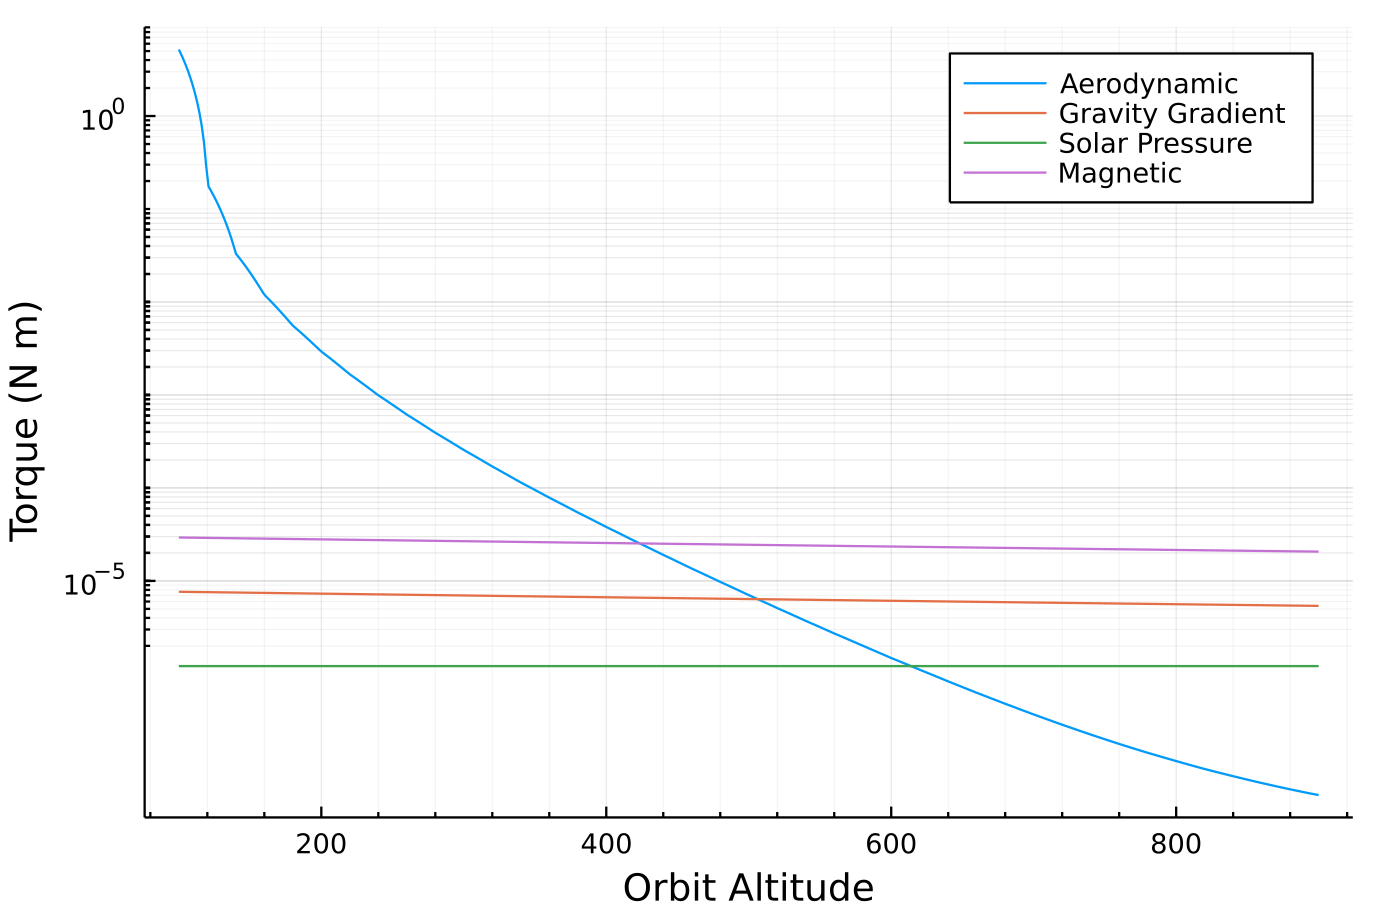

In [13]:
plot(
    orbit_alts, Ta, 
    yaxis=:log, 
    minorgrid=true,
    label="Aerodynamic",
    xlabel="Orbit Altitude",
    ylabel="Torque (N m)",
    dpi=230,
    fmt=:png
)

plot!(orbit_alts, Tg, label="Gravity Gradient")
plot!([orbit_alts[1], orbit_alts[end]], [Tsp, Tsp], label="Solar Pressure")
plot!(orbit_alts, Tm, label="Magnetic")

In [14]:
# getting max disturbance torques
max_torques = []

for i in 1:length(orbit_alts)
    push!(max_torques, maximum([Ta[i], Tm[i]]))
end

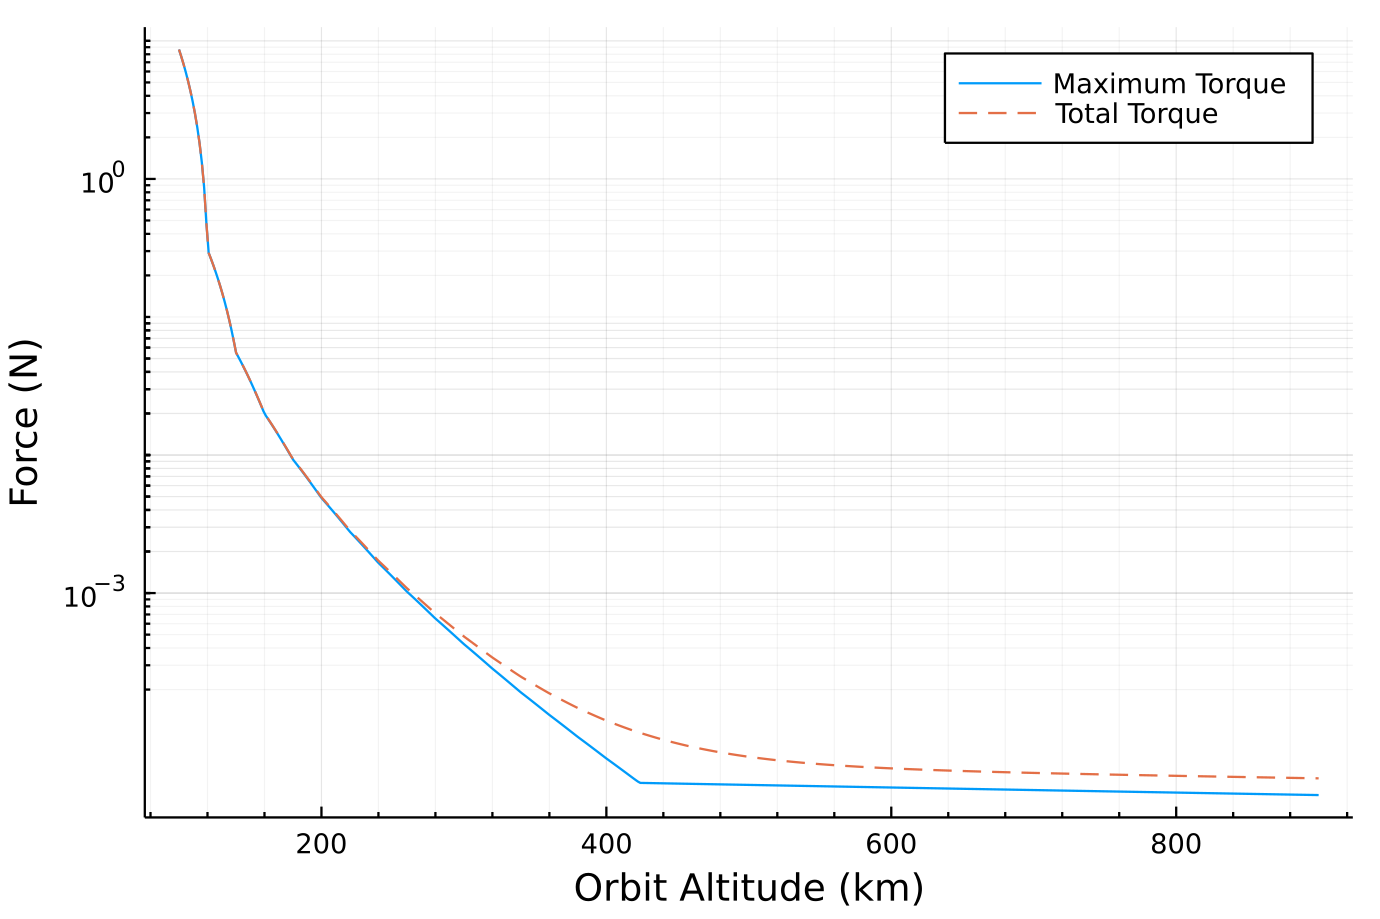

In [15]:
thruster_force = max_torques ./ 0.6

plot(
    orbit_alts, thruster_force, 
    yaxis=:log, 
    minorgrid=true,
    xlabel="Orbit Altitude (km)",
    ylabel="Force (N)",
    label="Maximum Torque",
    dpi=230,
    fmt=:png
)

plot!(
    orbit_alts,
    (Ta .+ Tg .+ [Tsp for i in 1:length(orbit_alts)] .+ Tm)./0.6,
    label="Total Torque",
    linestyle=:dash
)

In [16]:
# 250 km force
Falt = (0.5*density_interp(250)*Cd*A_s*((sqrt(μ / (re+250))*1e3)^2)*(Cg - Cp)) / 0.6

0.0013067078269144638

In [17]:
# total at 250 km
Falt_total = (0.5*density_interp(250)*Cd*A_s*((sqrt(μ / (re+250))*1e3)^2)*(Cg - Cp) + (3*μ/((re+250)^3)) * (J[3,3] - J[2,2]) * sin(2 * deg2rad(1)) + (Cg - Cp) * (1367 / 3e8) * A_s * (1 + q) * cos(i) + D * 7.96e15 / ((re+250)*1e3)^3)/0.6

0.0013661744016838866

In [21]:
# getting required reaction wheel sizing
orbit_periods = (2*π / sqrt(μ)) .* (re .+ orbit_alts).^(3/2)
hw = 0.707 .* max_torques .* orbit_periods ./ 4;

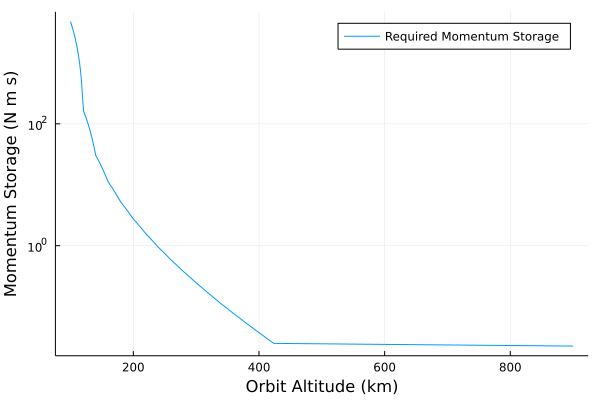

In [22]:
plot(
    orbit_alts, hw, 
    yaxis=:log, 
    label="Required Momentum Storage",
    xlabel="Orbit Altitude (km)",
    ylabel="Momentum Storage (N m s)"
)